In [115]:
import copy
import cv2
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [140]:
def label_voting(validate_result, threshold, image_shape, sliding_window_size, step, image_start):
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    voting = np.zeros((height + 4, width + 4))
    total = np.zeros((height + 4, width + 4))

    for j in range(height):
        for i in range(width):
            p = validate_result[i + j * width, 1]
            voting[j : j + 5, i : i + 5] += np.ones((5, 5)) * p
            total[j : j + 5, i : i + 5] += np.ones((5, 5))
    voting /= total
    voting = np.where(voting > threshold, 1, 0)

    labeled = []
    for j in range(height + 4):
        for i in range(width + 4):
            sliding_window = [image_start[1] + i * step, image_start[0] + j * step, image_start[1] + (i + 1) * step, image_start[0] + (j + 1) * step]
            if voting[j, i] == 1:
                labeled.append(sliding_window)
    return labeled

In [117]:
def save_labeled_image(image, boxes, file_name='output.jpg'):
    img = copy.deepcopy(image)
    color = np.array([3, 67, 223])
    box_width = 2
    for box in boxes:
        img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
        img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
        img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
        img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
    plt.imshow(img)
    plt.imsave(file_name, img)

In [118]:
model_name = "saved_model/hyperbola_vgg2.keras"
model = keras.models.load_model(model_name, compile = False)
model.compile()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      832       
                                                                 
 dropout_6 (Dropout)         (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      51264     
                                                                 
 dropout_7 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                  

In [133]:
IMAGE_START = 64
AXIS_ZERO = 44     # 1st dataset and 2nd dataset: 121, 3rd dataset: 44
image_start = [AXIS_ZERO, IMAGE_START]

image_path = "../data_preprocessing/unprocessed_images/ARR7_350_230324__001 P_31111111.JPG"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

height = math.ceil((img.shape[0] - sliding_window_size - image_start[0]) / step)
width = math.ceil((img.shape[1] - sliding_window_size - image_start[1]) / step)
number_image = height * width

[[0.06666    0.11763529 0.19605882 ... 0.18037412 0.56464941 0.38427529]
 [0.15684706 0.11763529 0.16468941 ... 0.16468941 0.41172353 0.33722118]
 [0.16076824 0.29016706 0.38819647 ... 0.15684706 0.34898471 0.32545765]
 ...
 [0.12547765 0.6666     0.29408824 ... 0.14900471 0.14116235 0.36466941]
 [0.15292588 0.70189059 0.14116235 ... 0.11763529 0.21958588 0.65875765]
 [0.17253176 0.58033412 0.14508353 ... 0.05881765 0.21174353 0.76070824]]
1/1 [==============================] - 0s 125ms/step
[[0.09392039 0.9060796 ]]


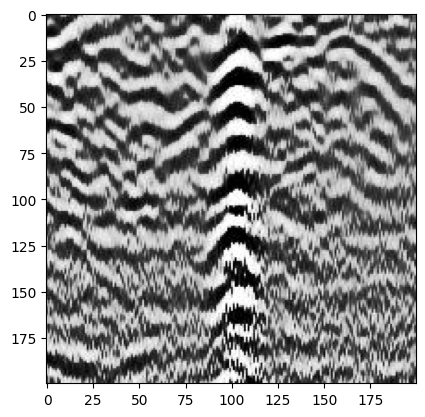

In [134]:
j, i = 0, 0
sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
rgb_weights = [0.2989, 0.5870, 0.1140]
sub_img = np.dot(sub_img[...,:3], rgb_weights)
sub_img = np.array(sub_img)
plt.imshow(sub_img, cmap="gray")
sub_img_normalize = sub_img / 255

print(sub_img_normalize)
print(model.predict(np.array([sub_img_normalize])))

In [135]:
count = 0
sub_images = np.zeros(shape=(number_image, 200, 200), dtype='float32')

for j in range(height):
    for i in range(width):
        sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
        sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
        rgb_weights = [0.2990, 0.5870, 0.1140]
        sub_img = np.dot(sub_img[...,:3], rgb_weights)
        sub_img = np.array(sub_img)

        sub_images[count] = sub_img / 255
        count += 1
        
print(sub_images.shape)

(10864, 200, 200)


In [136]:
validate_result = model.predict(sub_images)
print(validate_result.shape)

340/340 [==============================] - 237s 696ms/step
(10864, 2)


(847, 31280, 3)
[14, 776]


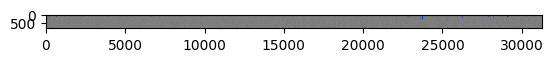

In [141]:
labeled = label_voting(validate_result, img.shape, sliding_window_size, step, [AXIS_ZERO, IMAGE_START])
save_labeled_image(img, labeled, file_name='output_lbp_hog_probability_cnn.jpg')

In [124]:
# loading testing data
from sklearn import datasets
from sklearn.utils import Bunch

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

testdata = np.load('SVM/2664_1st2ndDatasetA_testset_strong.npz')

pred_result = model.predict(testdata['data'])
pred_result = pred_result.astype(np.uint8)
print('Classification Training Report: \n', classification_report(testdata['label'], pred_result.T[1].T))

# confusion_matrix outputs how many samples are correctly or incorrectly classified
print('Train Confusion Matrix: \n', confusion_matrix(testdata['label'], pred_result.T[1].T), "\n")

# accuracy computes classification accuracy
print('Train Accuracy: ', accuracy_score(testdata['label'], pred_result.T[1].T))
print('\n')

84/84 [==============================] - 57s 675ms/step
Classification Training Report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      2220
           1       0.74      0.80      0.77       444

    accuracy                           0.92      2664
   macro avg       0.85      0.87      0.86      2664
weighted avg       0.92      0.92      0.92      2664

Train Confusion Matrix: 
 [[2098  122]
 [  91  353]] 

Train Accuracy:  0.920045045045045




1/1 [==============================] - 0s 68ms/step
[[0. 1.]]


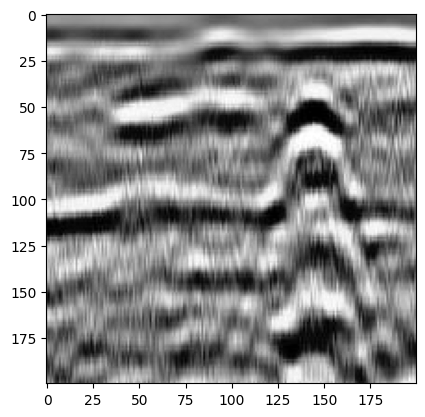

In [125]:
i = 21
pred_result = model.predict(np.array([testdata['data'][i]]))
print(pred_result)
plt.imshow(testdata['data'][i], cmap="gray")